### import library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import math

### Membaca Folder pada dataset

In [2]:
dataset = "dataset"
folders = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]

### Membaca file pada dataset

In [3]:
num_files = np.array([len(os.listdir(os.path.join(dataset, folder))) for folder in folders])

### Menampilkan jumlah file pada tiap folder

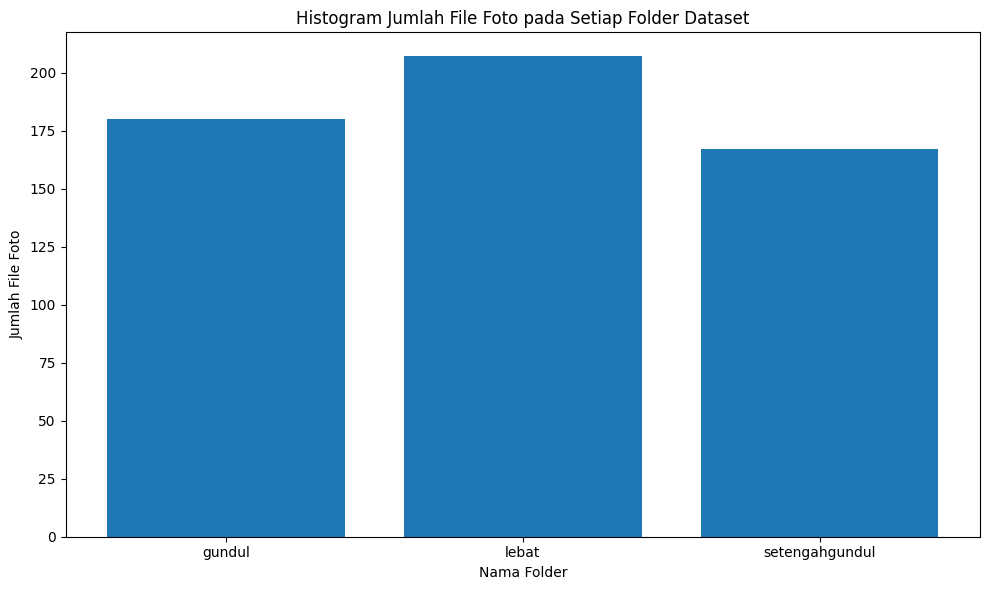

In [4]:
plt.figure(figsize=(10, 6))
plt.bar(folders, num_files)
plt.xlabel('Nama Folder')
plt.ylabel('Jumlah File Foto')
plt.title('Histogram Jumlah File Foto pada Setiap Folder Dataset')
plt.tight_layout()
plt.show()

### Mendefinisikan fungsi untuk membaca gambar

In [5]:
def insertGambar(folder, num_records, new_size=None):
    data = []
    labels = []
    filenames = []
    datalabel = []
    
    for label in os.listdir(folder):
        datalabel.append(label)
        print(f"Processing label: {label}")
        img_count = 0
        for filename in os.listdir(os.path.join(folder, label)):
            if img_count >= num_records:
                break
            img_path = os.path.join(folder, label, filename)
            img = cv2.imread(img_path)
            if img is not None:
                if new_size:
                    img = cv2.resize(img, new_size)
                data.append(img)
                labels.append(label)
                filenames.append(filename)
                img_count += 1

    return data, filenames, datalabel, labels

In [6]:
data, filenames, datalabel, labels = insertGambar(dataset, 120, new_size=(150, 150))

Processing label: gundul
Processing label: lebat
Processing label: setengahgundul


### Mendefinisikan fungsi untuk menampilkan gambar sesuai label

In [7]:
def imageByLabel(dataset):
    folders = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]
    
    fig, axs = plt.subplots(1, len(folders), figsize=(15, 5))
    for i, folder in enumerate(folders):
        folder_path = os.path.join(dataset, folder)
        image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg') or file.endswith('.png')]
        
        if len(image_files) > 0:
            random_image = random.choice(image_files)
            img_path = os.path.join(folder_path, random_image)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axs[i].imshow(img)
            axs[i].set_title(f"Label: {folder}")
            axs[i].axis('off')

    plt.show()

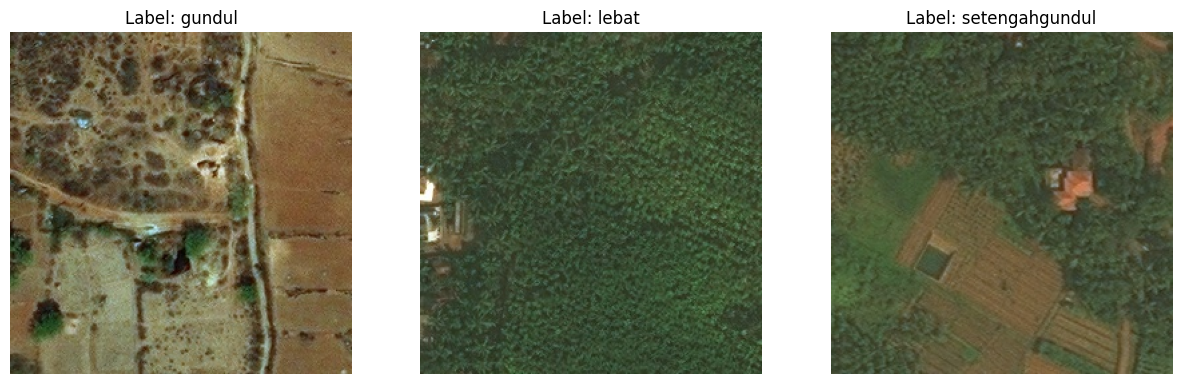

In [8]:
imageByLabel(dataset)

### Mendefinisikan fungsi rotate untuk keperluan augmentasi

In [9]:
def rotate(image, angle):
    height, width = image.shape[:2]

    center_x = width // 2
    center_y = height // 2

    angle_radian = np.radians(angle)

    cos_angle = np.cos(angle_radian)
    sin_angle = np.sin(angle_radian)
    
    rotated_image = np.zeros_like(image)
    for y in range(height):
        for x in range(width):
            new_x = int((x - center_x) * cos_angle - (y - center_y) * sin_angle + center_x)
            new_y = int((x - center_x) * sin_angle + (y - center_y) * cos_angle + center_y)

            if 0 <= new_x < width and 0 <= new_y < height:
                rotated_image[new_y, new_x] = image[y, x]
    
    return rotated_image

### melakukan augmentasi citra dengan merotasi 90 derajat 100 citra

In [10]:
num_photos = 100
count = 0

for i in range(len(data)):
    if count >= num_photos:
        break

    img = data[i]
    label = labels[i]

    rotated_image = rotate(img, 90)

    data.append(rotated_image)
    labels.append(label)
    
    count += 1

In [11]:
def show_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

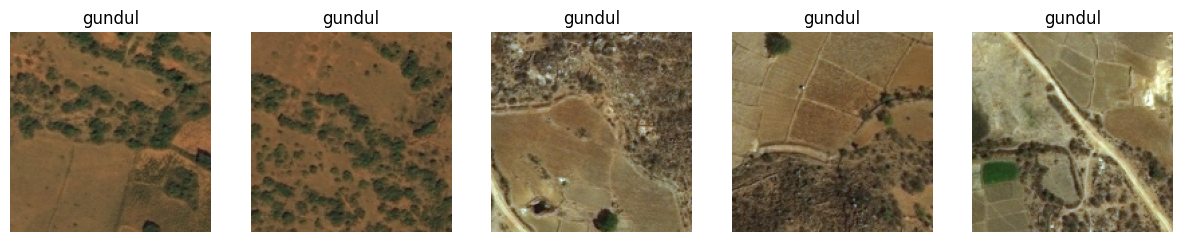

In [12]:
show_images(data[:5], labels[:5])

In [13]:
def displayRes(images, title):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(title + f' {i+1}')
    plt.show()

In [14]:
def rgb_to_hsv(image):
    image = image.astype(np.float32) / 255.0
    hsv_image = np.zeros_like(image)
    
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    
    v = np.max(image, axis=-1)
    
    diff = v - np.min(image, axis=-1)
    s = np.zeros_like(v)
    s[v != 0] = diff[v != 0] / v[v != 0]

    h = np.zeros_like(v)
    
    mask = diff != 0
    mask_r = (mask) & (v == r)
    mask_g = (mask) & (v == g)
    mask_b = (mask) & (v == b)
    
    h[mask_r] = (60 * ((g[mask_r] - b[mask_r]) / diff[mask_r]) + 360) % 360
    h[mask_g] = (60 * ((b[mask_g] - r[mask_g]) / diff[mask_g]) + 120) % 360
    h[mask_b] = (60 * ((r[mask_b] - g[mask_b]) / diff[mask_b]) + 240) % 360
    
    hsv_image[..., 0] = h
    hsv_image[..., 1] = s
    hsv_image[..., 2] = v

    hsv_image[..., 0] = hsv_image[..., 0] / 2
    
    return hsv_image

In [15]:
def in_range(hsv, lower_bound, upper_bound):
    mask = np.ones(hsv.shape[:2], dtype=np.uint8)
    
    for i in range(3):
        mask &= (hsv[..., i] >= lower_bound[i]) & (hsv[..., i] <= upper_bound[i])
    
    return mask

In [16]:
def bitwise(image, mask):
    result = np.zeros_like(image)

    for i in range(3):
        result[..., i] = image[..., i] * mask
    
    return result

In [17]:
def color_segmentation(images):
    segmented_images = []

    lower_green = np.array([30, 40 / 255, 40 / 255])
    upper_green = np.array([90, 255 / 255, 255 / 255])

    for image in images:
        hsv = rgb_to_hsv(np.copy(image))
        mask = in_range(hsv, lower_green, upper_green)
        segmented_image = bitwise(image, mask)
        segmented_images.append(np.copy(segmented_image))

    return segmented_images

In [18]:
segmented = color_segmentation(data)

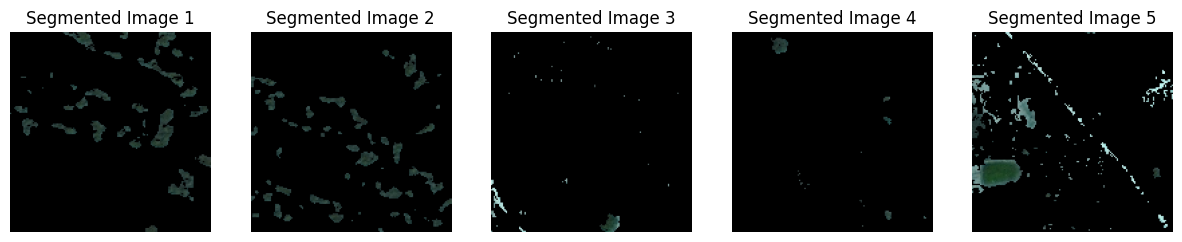

In [19]:
displayRes(segmented, "Segmented Image")

In [20]:
def calculate_histogram(image):
    hist = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        hist[pixel] += 1
    
    return hist

In [21]:
def calculate_cdf(hist):
    cdf = np.zeros_like(hist, dtype=float)
    cdf[0] = hist[0]
    for i in range(1, len(hist)):
        cdf[i] = cdf[i-1] + hist[i]
        
    return cdf

In [22]:
def normalize_cdf(cdf):
    cdf_min = cdf.min()
    cdf_max = cdf.max()
    
    if cdf_min == cdf_max:
        return np.full_like(cdf, 128, dtype='uint8')
    
    cdf_normalized = (cdf - cdf_min) * 255 / (cdf_max - cdf_min)
    
    return cdf_normalized.astype('uint8')

In [23]:
def apply_equalization(image, cdf_normalized):
    equalized_image = np.zeros_like(image, dtype='uint8')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            equalized_image[i, j] = cdf_normalized[image[i, j]]
            
    return equalized_image

In [24]:
def gray_to_bgr(gray_image):
    bgr_image = np.stack((gray_image,)*3, axis=-1)

    return bgr_image

In [25]:
def histogram_equalization(images):
    equalized_images = []

    for image in images:
        if len(image.shape) == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image

        hist = calculate_histogram(gray_image)
        cdf = calculate_cdf(hist)
        cdf_normalized = normalize_cdf(cdf)
        equalized_image = apply_equalization(gray_image, cdf_normalized)

        if len(image.shape) == 3:
            equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

        equalized_images.append(np.copy(equalized_image))

    return equalized_images

In [26]:
def enhance_image(images):
    enhanced_images = []

    for image in images:
        gray = cv2.cvtColor(np.copy(image), cv2.COLOR_BGR2GRAY)
        equalized_image = histogram_equalization([gray])
        enhanced_images.append(np.copy(equalized_image[0]))

    return enhanced_images

In [27]:
enhanced = enhance_image(segmented)

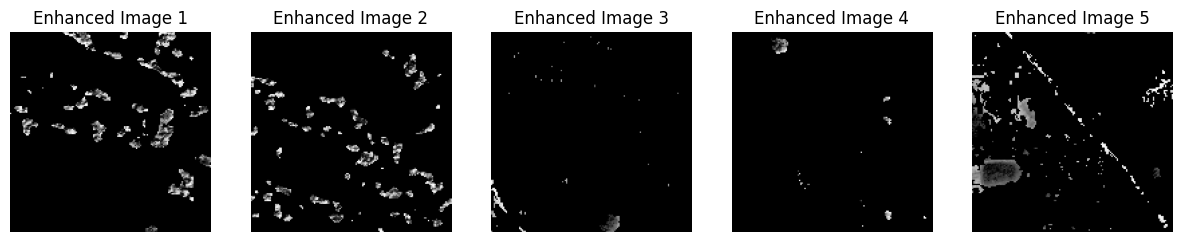

In [28]:
displayRes(enhanced, "Enhanced Image")

In [29]:
def normalize_images(images):
    normalized_images = []
    for img in images:
        img_float = img.astype(np.float32)

        min_val = np.min(img_float)
        max_val = np.max(img_float)
        
        if min_val == max_val:
            normalized_img = np.full_like(img, 128, dtype=np.uint8)
        else:
            normalized_img = (img_float - min_val) * (255.0 / (max_val - min_val))
            normalized_img = normalized_img.astype(np.uint8)

        normalized_images.append(np.copy(normalized_img))

    return normalized_images

In [30]:
normalized = normalize_images(enhanced)

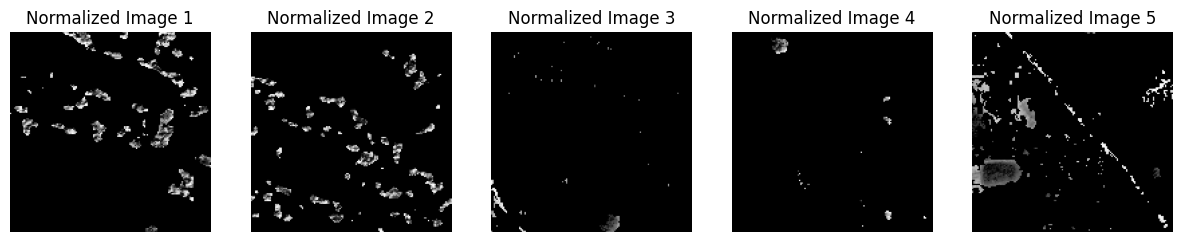

In [31]:
displayRes(normalized, "Normalized Image")

In [39]:
def erode(image, kernel):
    eroded_image = np.ones_like(image, dtype=np.uint8) * 255

    ksize = kernel.shape[0]
    pad_amount = ksize // 2

    padded_image = np.pad(image, pad_amount, mode='constant', constant_values=255)

    for i in range(pad_amount, padded_image.shape[0] - pad_amount):
        for j in range(pad_amount, padded_image.shape[1] - pad_amount):
            image_patch = padded_image[i-pad_amount:i+pad_amount+1, j-pad_amount:j+pad_amount+1]
            eroded_image[i-pad_amount, j-pad_amount] = np.min(image_patch)
    
    return eroded_image

In [40]:
def dilate(image, kernel):
    dilated_image = np.zeros_like(image, dtype=np.uint8)

    ksize = kernel.shape[0]
    pad_amount = ksize // 2

    padded_image = np.pad(image, pad_amount, mode='constant', constant_values=0)

    for i in range(pad_amount, padded_image.shape[0] - pad_amount):
        for j in range(pad_amount, padded_image.shape[1] - pad_amount):
            image_patch = padded_image[i-pad_amount:i+pad_amount+1, j-pad_amount:j+pad_amount+1]
            dilated_image[i-pad_amount, j-pad_amount] = np.max(image_patch)
    
    return dilated_image

In [41]:
def opening(images, kernel_size):
    opened_images = []
    
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    for image in images:
        if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 3):
            if len(image.shape) == 3:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray_image = image

            eroded_image = erode(gray_image, kernel)
            opened_image = dilate(eroded_image, kernel)
            
            opened_images.append(opened_image)
        else:
            print(f"Skipping image with invalid shape: {image.shape}")
    
    return opened_images

In [42]:
opened = opening(normalized, 2)

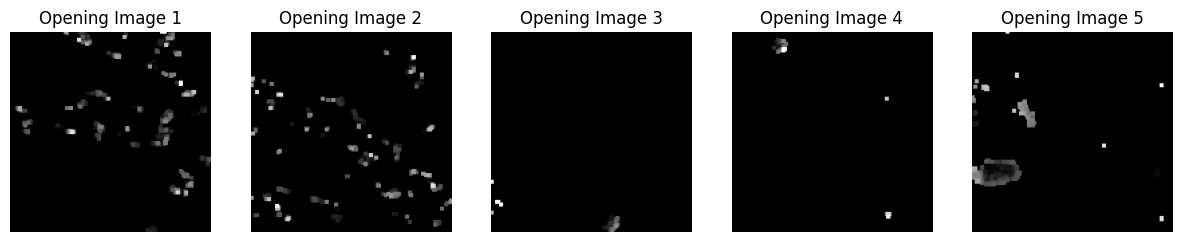

In [43]:
displayRes(opened, "Opening Image")

In [53]:
def convolve(image, kernel):
    img_height, img_width = image.shape
    ker_height, ker_width = kernel.shape

    pad_height = ker_height // 2
    pad_width = ker_width // 2

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    result = np.zeros_like(image)

    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i+ker_height, j:j+ker_width]
            result[i, j] = np.sum(region * kernel)
    
    return result

In [60]:
def sobel(image):
    gradien_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    gradien_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

    conv_gx = convolve(image, gradien_x)
    conv_gy = convolve(image, gradien_y)
    
    magnitude = np.sqrt(conv_gx**2 + conv_gy**2)
    
    if np.max(magnitude) != 0:
        magnitude = np.uint8(255 * magnitude / np.max(magnitude))
    else:
        magnitude = np.zeros_like(magnitude, dtype=np.uint8)

    return magnitude

In [55]:
def edge_detection(images):
    edge_images = []
    for image in images:
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        edges = sobel(gray)
        edge_images.append(edges)

    return edge_images

In [61]:
edge_detected = edge_detection(opened)

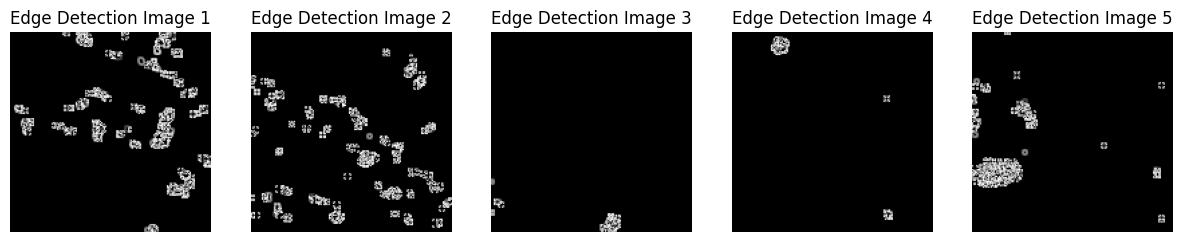

In [63]:
displayRes(edge_detected, "Edge Detection Image")

In [64]:
def glcm0(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)):
        for j in range(len(img[i])-1):
            imgTemp[img[i, j], img[i, j+1]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

In [65]:
def glcm45(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            imgTemp[img[i+1, j], img[i, j+1]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

In [66]:
def glcm90(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)-1):
        for j in range(len(img[i])):
            imgTemp[img[i+1, j], img[i, j]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

In [67]:
def glcm135(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            imgTemp[img[i, j], img[i+1, j+1]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

In [153]:
hasil_ori = []
for img in data:
    res_ori = []
    res_ori.append(glcm0(img))
    res_ori.append(glcm45(img))
    res_ori.append(glcm90(img))
    res_ori.append(glcm135(img))
    hasil_ori.append(res_ori)

In [68]:
hasil = []
for img in edge_detected:
    res = []
    res.append(glcm0(img))
    res.append(glcm45(img))
    res.append(glcm90(img))
    res.append(glcm135(img))
    hasil.append(res)

In [69]:
def contrast(data):
    contrast = 0
    for i in range(len(data)):
        for j in range(len(data)):
            contrast += data[i,j] + (i-j)**2
            
    return contrast

In [70]:
def dissimilarity(data):
    diss = 0
    for i in range (len(data)):
        for j in range(len(data)):
            diss += data[i,j] + abs(i-j)
            
    return diss

In [71]:
def homogenity(data):
    homogen = 0
    for i in range (len(data)):
        for j in range(len(data)):
            homogen += data[i,j] / (1 + abs(i-j))

    return homogen

In [72]:
def energy(data):
    energy = 0
    for i in range (len(data)):
        for j in range(len(data)):
            energy += pow(data[i,j], 2)
    return energy

In [160]:
def calculate_correlation(data, mean_i, mean_j, std_dev_i, std_dev_j):
    if std_dev_i == 0 or std_dev_j == 0:
        return 0
    
    corr = 0
    for i in range(len(data)):
        for j in range(len(data)):
            corr += ((i - mean_i) * (j - mean_j) * data[i, j]) / (std_dev_i * std_dev_j)
            
    return corr

In [74]:
def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data)):
            if data[i,j] > 0:
                entropy += -(data[i,j] * math.log(data[i,j]))
                
    return entropy

In [75]:
def ASM(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
            
    return asm

In [84]:
def mean_i(data):
    mean_value = 0
    for i in range(len(data)):
        for j in range(len(data)):
            mean_value += i * data[i, j]

    return mean_value

In [85]:
def mean_j(data):
    mean_value = 0
    for i in range(len(data)):
        for j in range(len(data)):
            mean_value += j * data[i, j]

    return mean_value

In [87]:
def std_dev_i(data, mean_i_value):
    std_dev_value = 0
    
    for i in range(len(data)):
        for j in range(len(data)):
            std_dev_value += pow((i - mean_i_value), 2) * data[i, j]

    std_dev_value = math.sqrt(std_dev_value)

    return std_dev_value

In [88]:
def std_dev_j(data, mean_j_value):
    std_dev_value = 0
    
    for i in range(len(data)):
        for j in range(len(data)):
            std_dev_value += pow((j - mean_j_value), 2) * data[i, j]

    std_dev_value = math.sqrt(std_dev_value)
    
    return std_dev_value

In [171]:
headerCols = ['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
            'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135',
            'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135',
            'energy_0', 'energy_45', 'energy_90', 'energy_135',
            'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135',
            'entropy_0', 'entropy_45', 'entropy_90', 'entropy_135',
            'asm_0', 'asm_45', 'asm_90', 'asm_135', 'labels']

In [159]:
def featureAnalysis(result, labels):
    part = []
    correlation_val = []

    for i, glcm_matrix in enumerate(result):
        save = []

        for j in glcm_matrix:
            kontras = contrast(j)
            save.append(kontras)

            diss = dissimilarity(j)
            save.append(diss)

            hom = homogenity(j)
            save.append(hom)

            eng = energy(j)
            save.append(eng)
            
            mI = meanI(j)
            mJ = meanJ(j)
            sDI = standDevI(j, mI)
            sDJ = standDevJ(j, mJ)
            corr = calculate_correlation(j, mI, mJ, sDI, sDJ)
            save.append(corr)
            
            ent = entropy(j)
            save.append(ent)
            
            asm_value = ASM(j)
            save.append(asm_value)

        save.append(labels[i])
        part.append(save)

        if all(value != 0 for value in [kontras, diss, hom, eng, corr, ent, asm_value]):
            correlation_val.append((kontras, diss, hom, eng, corr, ent, asm_value))

    return part, correlation_val

In [161]:
part_original, corr_value = featureAnalysis(hasil_ori, labels)

In [173]:
df = pd.DataFrame(part_original, columns=headerCols)

In [198]:
def normalize(train, test):
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    
    min_vals = train.min(axis=0)
    max_vals = train.max(axis=0)
    
    train_normalized = (train - min_vals) / (max_vals - min_vals)
    test_normalized = (test - min_vals) / (max_vals - min_vals)
    
    return train_normalized, test_normalized

In [201]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [202]:
def evaluate_model(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f'{model_name} - Accuracy: {accuracy:.6f}')
    print(f'{model_name} - Precision: {precision:.6f}')
    print(f'{model_name} - Recall: {recall:.6f}')
    print(f'{model_name} - F1-Score: {f1:.6f}')
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'\nConfusion Matrix for {model_name}:')
    print(conf_matrix)
    
    plt.figure(figsize=(8, 6))
    mask = (np.eye(len(conf_matrix)) == 1)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', mask=mask, cbar=False)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', mask=~mask, cbar=False)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    return accuracy, precision, recall, f1

In [165]:
correlationSorted = sorted(corr_value, key = lambda x: x[-1], reverse=True)
top5_correlations = correlationSorted[:5]

for correlation in top5_correlations:
    kontras, diss, hom, eng, ent, asm, corr = correlation
    print("Contrast: {}, Dissimilarity: {}, Homogeneity: {}, Energy: {}, Entropy: {}, Correlation: {}, ASM: {}".format(kontras, diss, hom, eng, ent, corr, asm))

Contrast: 35724040.99999929, Dissimilarity: 590480.9999999861, Homogeneity: 0.2556390045367817, Energy: 0.0013576241688514614, Entropy: 0.7318030724195838, Correlation: 0.0013576241688514614, ASM: 7.168410701711749
Contrast: 27172433.000000317, Dissimilarity: 480929.0000000061, Homogeneity: 0.24356068458144695, Energy: 0.0013466536226669971, Entropy: 0.5253358121488964, Correlation: 0.0013466536226669971, ASM: 7.148904020817699
Contrast: 35724041.00000114, Dissimilarity: 590481.000000013, Homogeneity: 0.23808021956303338, Energy: 0.0012375274478976545, Entropy: 0.5467750883237906, Correlation: 0.0012375274478976545, ASM: 7.298700630323136
Contrast: 34557601.00000092, Dissimilarity: 575960.999999983, Homogeneity: 0.24298606959537797, Energy: 0.0011448340329290685, Entropy: 0.6374121574664479, Correlation: 0.0011448340329290685, ASM: 7.357119457527205
Contrast: 79960553.00000504, Dissimilarity: 1080549.000000028, Homogeneity: 0.25556782483847457, Energy: 0.0011340028774717847, Entropy: 0

In [192]:
df.to_csv('hasilPercobaan3_original.csv',index=False)

In [193]:
results_ori = pd.read_csv('hasilPercobaan3_original.csv')
results_ori

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,entropy_0,entropy_45,entropy_90,entropy_135,asm_0,asm_45,asm_90,asm_135,labels
0,1.563100e+08,1.786401e+06,0.273404,0.000521,0.957049,8.050887,0.000521,1.563100e+08,1.786401e+06,0.241591,...,8.185899,0.000465,1.563100e+08,1.786401e+06,0.239697,0.000430,0.924681,8.278883,0.000430,gundul
1,9.870276e+07,1.265421e+06,0.258627,0.000509,0.948812,8.045545,0.000509,9.870276e+07,1.265421e+06,0.225281,...,8.158310,0.000463,9.870276e+07,1.265421e+06,0.225877,0.000421,0.911318,8.264633,0.000421,gundul
2,6.937083e+08,5.462271e+06,0.185760,0.000196,0.880890,8.934065,0.000196,6.937083e+08,5.462271e+06,0.159872,...,8.999593,0.000181,6.937083e+08,5.462271e+06,0.169016,0.000169,0.819401,9.088853,0.000169,gundul
3,6.828480e+08,5.398009e+06,0.210396,0.000243,0.929353,8.630762,0.000243,6.828480e+08,5.398009e+06,0.183050,...,8.745404,0.000217,6.828480e+08,5.398009e+06,0.182902,0.000197,0.879137,8.848902,0.000197,gundul
4,7.158170e+08,5.592321e+06,0.191683,0.000180,0.920213,9.078148,0.000180,7.158170e+08,5.592321e+06,0.164966,...,9.060133,0.000179,7.158170e+08,5.592321e+06,0.182097,0.000163,0.905318,9.154707,0.000163,gundul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,1.492859e+08,1.725849e+06,0.242677,0.000360,0.887010,8.288631,0.000360,1.492859e+08,1.725849e+06,0.228418,...,8.194713,0.000395,1.492859e+08,1.725849e+06,0.222989,0.000314,0.852072,8.435744,0.000314,gundul
456,8.896195e+07,1.170553e+06,0.285924,0.000527,0.927191,7.981818,0.000527,8.896195e+07,1.170553e+06,0.274975,...,7.886825,0.000569,8.896195e+07,1.170553e+06,0.272548,0.000483,0.906192,8.094410,0.000483,gundul
457,1.599136e+08,1.817201e+06,0.239559,0.000365,0.905693,8.352164,0.000365,1.599136e+08,1.817201e+06,0.227686,...,8.273124,0.000393,1.599136e+08,1.817201e+06,0.222192,0.000324,0.872418,8.490704,0.000324,gundul
458,1.994748e+08,2.144891e+06,0.243870,0.000456,0.915570,8.229786,0.000456,1.994748e+08,2.144891e+06,0.231554,...,8.141770,0.000491,1.994748e+08,2.144891e+06,0.224561,0.000410,0.883569,8.373923,0.000410,gundul


In [182]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer

In [179]:
def features_score(data, label_column):
    X = data.drop(columns=[label_column])
    y = data[label_column]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    min_val = np.min(X_imputed)
    if min_val < 0:
        X_imputed += abs(min_val)

    selector = SelectKBest(score_func=chi2)
    selector.fit(X_imputed, y)

    scores = selector.scores_

    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})

    feature_scores = feature_scores.sort_values(by='Score', ascending=False)

    return feature_scores

In [194]:
best_features_ori = features_score(results_ori, 'labels')

print("Fitur terbaik berdasarkan skor:")
print(best_features_ori)

Fitur terbaik berdasarkan skor:
              Feature         Score
0          contrast_0  6.323447e+09
14          energy_90  6.323447e+09
21         entropy_45  6.323447e+09
7   dissimilarity_135  6.323447e+09
22         entropy_90  4.094654e+07
1         contrast_45  4.094654e+07
15         energy_135  4.094654e+07
8       homogeneity_0  4.094654e+07
25             asm_45  5.419837e+00
11    homogeneity_135  4.197520e+00
18     correlation_90  3.442470e+00
12           energy_0  2.864764e+00
26             asm_90  2.718409e+00
5    dissimilarity_45  2.669076e+00
19    correlation_135  2.352722e+00
4     dissimilarity_0  1.980471e+00
23        entropy_135  8.409091e-01
16      correlation_0  8.070852e-01
9      homogeneity_45  6.085105e-01
2         contrast_90  4.889117e-01
3        contrast_135  7.660781e-03
6    dissimilarity_90  7.660781e-03
13          energy_45  6.826309e-03
10     homogeneity_90  6.826309e-03
24              asm_0  6.432954e-03
27            asm_135  6.432954e

In [197]:
dataTrain_ori = pd.read_csv('hasilPercobaan3_original.csv')

X = dataTrain_ori[['contrast_0', 'energy_90', 'entropy_45', 'dissimilarity_135', 'entropy_90', 'contrast_45', 'energy_135', 'homogeneity_0', 'asm_45', 'homogeneity_135', 'correlation_90', 'energy_0']]
y = dataTrain_ori['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [199]:
X_train_scaled, X_test_scaled = normalize(X_train, X_test)

In [200]:
print("Data Pelatihan Setelah Normalisasi Min-Max:")
print(X_train_scaled)
print("\nData Pengujian Setelah Normalisasi Min-Max:")
print(X_test_scaled)

Data Pelatihan Setelah Normalisasi Min-Max:
     contrast_0  energy_90  entropy_45  dissimilarity_135  entropy_90  \
108    0.184794   0.184794    0.184794           0.184794    0.259134   
428    0.620345   0.620345    0.620345           0.620345    0.687848   
430    0.728242   0.728242    0.728242           0.728242    0.780368   
118    0.204889   0.204889    0.204889           0.204889    0.282163   
114    0.184794   0.184794    0.184794           0.184794    0.259134   
..          ...        ...         ...                ...         ...   
106    0.273944   0.273944    0.273944           0.273944    0.357772   
270    0.430997   0.430997    0.430997           0.430997    0.515256   
348    1.000000   1.000000    1.000000           1.000000    1.000000   
435    0.544804   0.544804    0.544804           0.544804    0.620758   
102    0.124719   0.124719    0.124719           0.124719    0.186616   

     contrast_45  energy_135  homogeneity_0    asm_45  homogeneity_135  \
108  

K-Nearest Neighbors - Accuracy: 0.833333
K-Nearest Neighbors - Precision: 0.810288
K-Nearest Neighbors - Recall: 0.824783
K-Nearest Neighbors - F1-Score: 0.816374

Confusion Matrix for K-Nearest Neighbors:
[[70  3  9]
 [ 0 27  0]
 [11  0 18]]


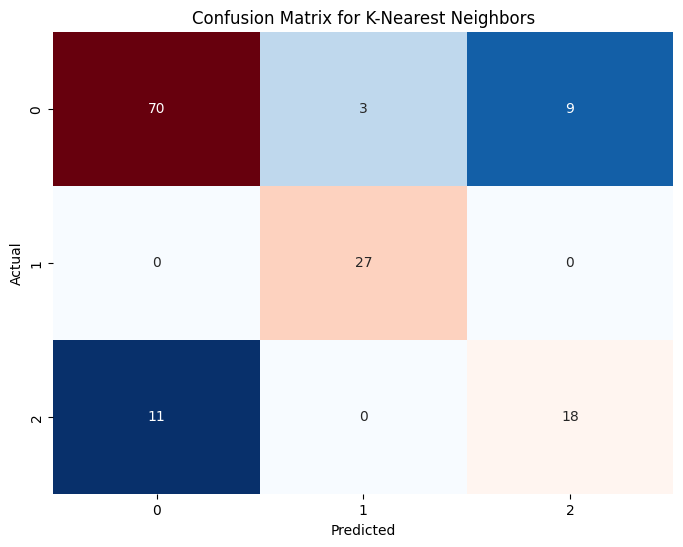

In [203]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_metrics = evaluate_model(knn_model, X_test_scaled, y_test, 'K-Nearest Neighbors')

SVM - Accuracy: 0.811594
SVM - Precision: 0.786749
SVM - Recall: 0.760583
SVM - F1-Score: 0.760374

Confusion Matrix for SVM:
[[74  2  6]
 [ 0 27  0]
 [17  1 11]]


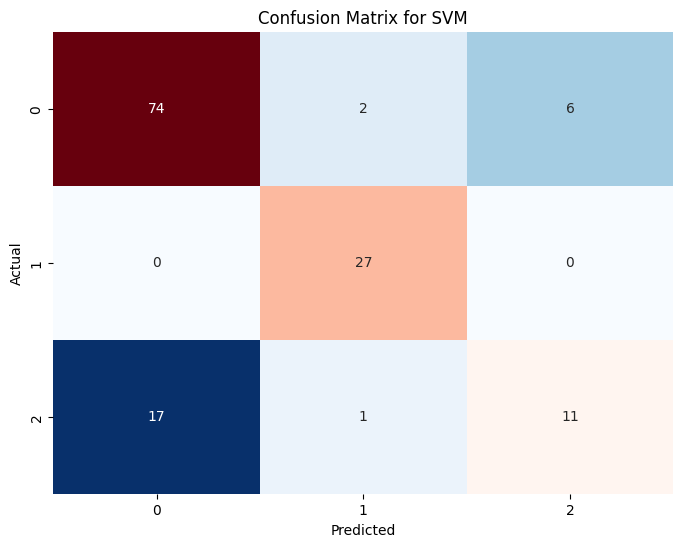

In [204]:
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
svm_metrics = evaluate_model(svm_model, X_test_scaled, y_test, 'SVM')

Random Forest - Accuracy: 0.797101
Random Forest - Precision: 0.760555
Random Forest - Recall: 0.789599
Random Forest - F1-Score: 0.773420

Confusion Matrix for Random Forest:
[[67  2 13]
 [ 0 27  0]
 [11  2 16]]


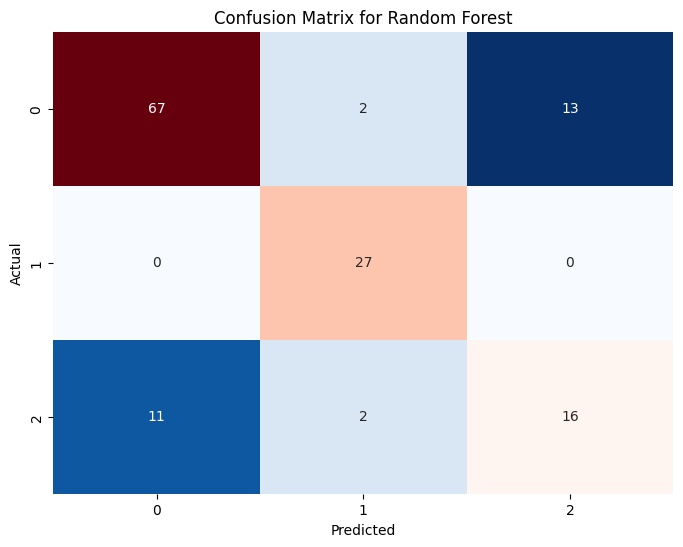

In [205]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest')

In [89]:
part, correlation_val = featureAnalysis(hasil, labels)

In [90]:
df = pd.DataFrame(part, columns=headerCols)

In [91]:
correlationSorted = sorted(correlation_val, key = lambda x: x[-1], reverse=True)
top5_correlations = correlationSorted[:5]

for correlation in top5_correlations:
    kontras, diss, hom, eng, ent, asm, corr = correlation
    print("Contrast: {}, Dissimilarity: {}, Homogeneity: {}, Energy: {}, Entropy: {}, Correlation: {}, ASM: {}".format(kontras, diss, hom, eng, ent, corr, asm))

Contrast: 715816961.0000001, Dissimilarity: 5592321.0, Homogeneity: 0.9991064826840823, Energy: 0.9981991882920227, Entropy: 0.28543163935089455, Correlation: 0.9981991882920227, ASM: 0.009197464291786986
Contrast: 715816961.0000001, Dissimilarity: 5592321.0, Homogeneity: 0.9991064826840823, Energy: 0.9981991882920227, Entropy: 0.28543163935089455, Correlation: 0.9981991882920227, ASM: 0.009197464291786986
Contrast: 704697601.0, Dissimilarity: 5527040.999999999, Homogeneity: 0.998680278259149, Energy: 0.9969395947671712, Entropy: 0.6040350727667738, Correlation: 0.9969395947671712, ASM: 0.015561007032584563
Contrast: 704697601.0, Dissimilarity: 5527040.999999999, Homogeneity: 0.998680278259149, Energy: 0.9969395947671712, Entropy: 0.6040350727667738, Correlation: 0.9969395947671712, ASM: 0.015561007032584563
Contrast: 704697601.0000005, Dissimilarity: 5527041.0, Homogeneity: 0.9983226745241603, Energy: 0.9963998901235277, Entropy: 0.5652074516682587, Correlation: 0.9963998901235277, AS

In [186]:
df.to_csv('hasilPercobaan3.csv',index=False)

In [195]:
results = pd.read_csv('hasilPercobaan3.csv')
# results = results.drop(columns=['path'])
results

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,entropy_0,entropy_45,entropy_90,entropy_135,asm_0,asm_45,asm_90,asm_135,labels
0,1.563100e+08,1.786401e+06,0.273404,0.000521,0.957049,8.050887,0.000521,1.563100e+08,1.786401e+06,0.241591,...,8.185899,0.000465,1.563100e+08,1.786401e+06,0.239697,0.000430,0.924681,8.278883,0.000430,gundul
1,9.870276e+07,1.265421e+06,0.258627,0.000509,0.948812,8.045545,0.000509,9.870276e+07,1.265421e+06,0.225281,...,8.158310,0.000463,9.870276e+07,1.265421e+06,0.225877,0.000421,0.911318,8.264633,0.000421,gundul
2,6.937083e+08,5.462271e+06,0.185760,0.000196,0.880890,8.934065,0.000196,6.937083e+08,5.462271e+06,0.159872,...,8.999593,0.000181,6.937083e+08,5.462271e+06,0.169016,0.000169,0.819401,9.088853,0.000169,gundul
3,6.828480e+08,5.398009e+06,0.210396,0.000243,0.929353,8.630762,0.000243,6.828480e+08,5.398009e+06,0.183050,...,8.745404,0.000217,6.828480e+08,5.398009e+06,0.182902,0.000197,0.879137,8.848902,0.000197,gundul
4,7.158170e+08,5.592321e+06,0.191683,0.000180,0.920213,9.078148,0.000180,7.158170e+08,5.592321e+06,0.164966,...,9.060133,0.000179,7.158170e+08,5.592321e+06,0.182097,0.000163,0.905318,9.154707,0.000163,gundul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,1.492859e+08,1.725849e+06,0.242677,0.000360,0.887010,8.288631,0.000360,1.492859e+08,1.725849e+06,0.228418,...,8.194713,0.000395,1.492859e+08,1.725849e+06,0.222989,0.000314,0.852072,8.435744,0.000314,gundul
456,8.896195e+07,1.170553e+06,0.285924,0.000527,0.927191,7.981818,0.000527,8.896195e+07,1.170553e+06,0.274975,...,7.886825,0.000569,8.896195e+07,1.170553e+06,0.272548,0.000483,0.906192,8.094410,0.000483,gundul
457,1.599136e+08,1.817201e+06,0.239559,0.000365,0.905693,8.352164,0.000365,1.599136e+08,1.817201e+06,0.227686,...,8.273124,0.000393,1.599136e+08,1.817201e+06,0.222192,0.000324,0.872418,8.490704,0.000324,gundul
458,1.994748e+08,2.144891e+06,0.243870,0.000456,0.915570,8.229786,0.000456,1.994748e+08,2.144891e+06,0.231554,...,8.141770,0.000491,1.994748e+08,2.144891e+06,0.224561,0.000410,0.883569,8.373923,0.000410,gundul


In [196]:
best_features = features_score(results, 'labels')

print("Fitur terbaik berdasarkan skor:")
print(best_features)

Fitur terbaik berdasarkan skor:
              Feature         Score
0          contrast_0  6.323447e+09
14          energy_90  6.323447e+09
21         entropy_45  6.323447e+09
7   dissimilarity_135  6.323447e+09
22         entropy_90  4.094654e+07
1         contrast_45  4.094654e+07
15         energy_135  4.094654e+07
8       homogeneity_0  4.094654e+07
25             asm_45  5.419837e+00
11    homogeneity_135  4.197520e+00
18     correlation_90  3.442470e+00
12           energy_0  2.864764e+00
26             asm_90  2.718409e+00
5    dissimilarity_45  2.669076e+00
19    correlation_135  2.352722e+00
4     dissimilarity_0  1.980471e+00
23        entropy_135  8.409091e-01
16      correlation_0  8.070852e-01
9      homogeneity_45  6.085105e-01
2         contrast_90  4.889117e-01
3        contrast_135  7.660781e-03
6    dissimilarity_90  7.660781e-03
13          energy_45  6.826309e-03
10     homogeneity_90  6.826309e-03
24              asm_0  6.432954e-03
27            asm_135  6.432954e

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
dataTrain = pd.read_csv('hasilPercobaan3.csv')
dataTrain = dataTrain.drop(columns=['path'])

In [115]:
X = dataTrain[['entropy_45', 'dissimilarity_135', 'contrast_0', 'energy_90', 'homogeneity_0', 'entropy_90', 'contrast_45', 'energy_135', 'asm_90', 'energy_0', 'correlation_135', 'dissimilarity_45']]
y = dataTrain['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
X_train_scaled, X_test_scaled = normalize(X_train, X_test)

In [118]:
print("Data Pelatihan Setelah Normalisasi Min-Max:")
print(X_train_scaled)
print("\nData Pengujian Setelah Normalisasi Min-Max:")
print(X_test_scaled)

Data Pelatihan Setelah Normalisasi Min-Max:
     entropy_45  dissimilarity_135  contrast_0  energy_90  homogeneity_0  \
108         0.0                0.0         0.0        0.0            0.0   
428         1.0                1.0         1.0        1.0            1.0   
430         0.0                0.0         0.0        0.0            0.0   
118         1.0                1.0         1.0        1.0            1.0   
114         1.0                1.0         1.0        1.0            1.0   
..          ...                ...         ...        ...            ...   
106         1.0                1.0         1.0        1.0            1.0   
270         1.0                1.0         1.0        1.0            1.0   
348         1.0                1.0         1.0        1.0            1.0   
435         1.0                1.0         1.0        1.0            1.0   
102         1.0                1.0         1.0        1.0            1.0   

     entropy_90  contrast_45  energy_135   

K-Nearest Neighbors - Accuracy: 0.934783
K-Nearest Neighbors - Precision: 0.932773
K-Nearest Neighbors - Recall: 0.909707
K-Nearest Neighbors - F1-Score: 0.920576

Confusion Matrix for K-Nearest Neighbors:
[[80  0  2]
 [ 0 25  2]
 [ 5  0 24]]


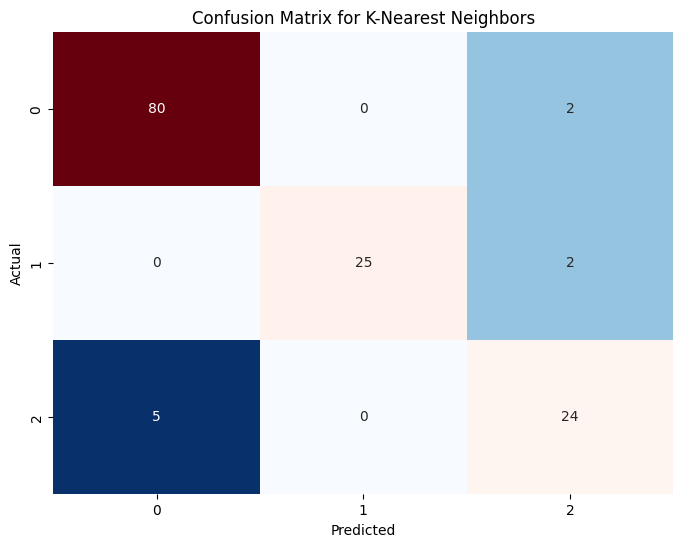

In [119]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_metrics = evaluate_model(knn_model, X_test_scaled, y_test, 'K-Nearest Neighbors')

SVM - Accuracy: 0.934783
SVM - Precision: 0.921856
SVM - Recall: 0.910559
SVM - F1-Score: 0.915225

Confusion Matrix for SVM:
[[80  0  2]
 [ 0 26  1]
 [ 4  2 23]]


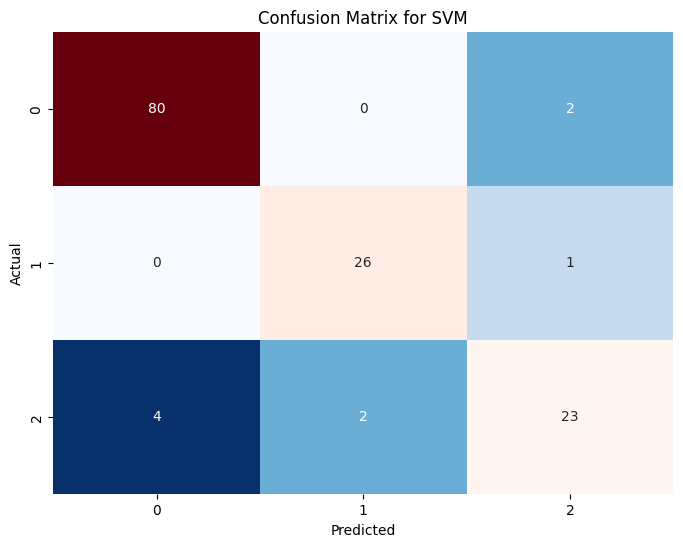

In [120]:
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
svm_metrics = evaluate_model(svm_model, X_test_scaled, y_test, 'SVM')

Random Forest - Accuracy: 0.913043
Random Forest - Precision: 0.911140
Random Forest - Recall: 0.882654
Random Forest - F1-Score: 0.895910

Confusion Matrix for Random Forest:
[[79  0  3]
 [ 0 25  2]
 [ 7  0 22]]


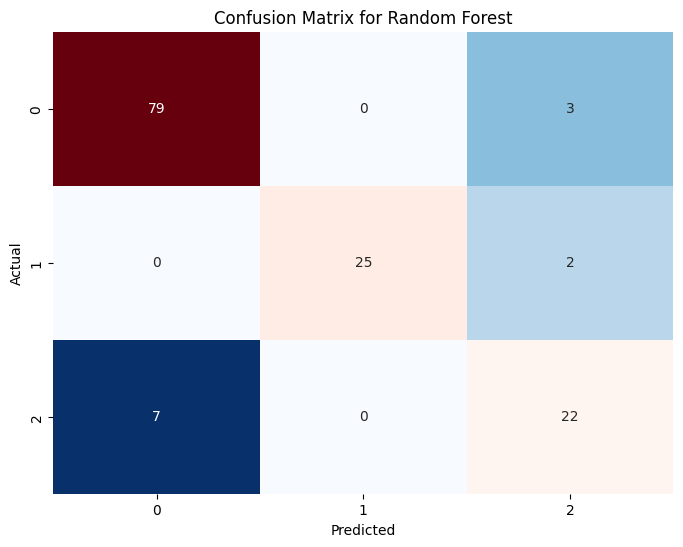

In [121]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest')

In [122]:
modelResults = {
    'Model': ['K-Nearest Neighbors', 'SVM', 'Random Forest'],
    'Accuracy': [knn_metrics[0], svm_metrics[0], rf_metrics[0]],
    'Precision': [knn_metrics[1], svm_metrics[1], rf_metrics[1]],
    'Recall': [knn_metrics[2], svm_metrics[2], rf_metrics[2]],
    'F1-Score': [knn_metrics[3], svm_metrics[3], rf_metrics[3]]
}

In [123]:
modelResults_df = pd.DataFrame(modelResults)
print(modelResults_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0  K-Nearest Neighbors  0.934783   0.932773  0.909707  0.920576
1                  SVM  0.934783   0.921856  0.910559  0.915225
2        Random Forest  0.913043   0.911140  0.882654  0.895910


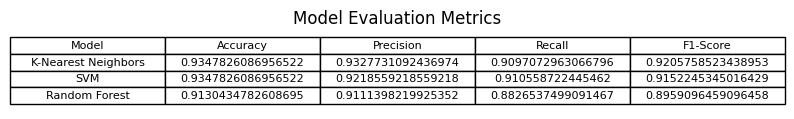

In [124]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=modelResults_df.values, colLabels=modelResults_df.columns, cellLoc='center', loc='center')
plt.title('Model Evaluation Metrics')
plt.show()

In [125]:
def display_predictions(model, X_test_scaled, y_test, num_samples=50):
    y_pred = model.predict(X_test_scaled)
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    
    print(f"Displaying {num_samples} predictions for the model:")
    print(results.sample(num_samples))

In [126]:
display_predictions(knn_model, X_test_scaled, y_test)

Displaying 50 predictions for the model:
             Actual       Predicted
94           gundul          gundul
425          gundul          gundul
19           gundul          gundul
101          gundul          gundul
405          gundul          gundul
132           lebat           lebat
305  setengahgundul  setengahgundul
154           lebat  setengahgundul
0            gundul          gundul
429          gundul          gundul
231           lebat  setengahgundul
406          gundul          gundul
447          gundul  setengahgundul
434          gundul          gundul
60           gundul          gundul
46           gundul          gundul
397          gundul          gundul
246  setengahgundul  setengahgundul
193           lebat           lebat
323  setengahgundul  setengahgundul
426          gundul          gundul
289  setengahgundul          gundul
15           gundul          gundul
66           gundul          gundul
450          gundul          gundul
436          gundul    

In [127]:
display_predictions(rf_model, X_test_scaled, y_test)

Displaying 50 predictions for the model:
             Actual       Predicted
82           gundul          gundul
291  setengahgundul          gundul
22           gundul          gundul
294  setengahgundul  setengahgundul
248  setengahgundul  setengahgundul
46           gundul          gundul
45           gundul          gundul
30           gundul          gundul
402          gundul          gundul
323  setengahgundul  setengahgundul
78           gundul          gundul
210           lebat           lebat
124           lebat           lebat
181           lebat           lebat
192           lebat           lebat
290  setengahgundul  setengahgundul
346  setengahgundul  setengahgundul
405          gundul          gundul
33           gundul          gundul
417          gundul          gundul
246  setengahgundul          gundul
172           lebat           lebat
19           gundul          gundul
15           gundul          gundul
55           gundul          gundul
173           lebat    

In [128]:
display_predictions(svm_model, X_test_scaled, y_test)

Displaying 50 predictions for the model:
             Actual       Predicted
249  setengahgundul  setengahgundul
209           lebat           lebat
294  setengahgundul  setengahgundul
323  setengahgundul  setengahgundul
417          gundul          gundul
70           gundul          gundul
238           lebat           lebat
404          gundul          gundul
429          gundul          gundul
431          gundul          gundul
16           gundul          gundul
140           lebat           lebat
46           gundul          gundul
247  setengahgundul          gundul
433          gundul          gundul
237           lebat           lebat
304  setengahgundul  setengahgundul
19           gundul          gundul
42           gundul          gundul
57           gundul          gundul
11           gundul          gundul
410          gundul          gundul
451          gundul          gundul
56           gundul          gundul
193           lebat           lebat
60           gundul    